In [2]:
import torch
import torch.nn as nn
from utils.model import GCN
from utils.h36motion3d import H36motion3D
from torch.utils.data import DataLoader
import utils.model as nnmodel
from utils.opt import Options
import numpy as np
import matplotlib.pyplot as plt

In [3]:
input_n = 10
output_n = 25

train_dataset = H36motion3D(path_to_data='./h3.6m/dataset', actions='all', input_n=input_n, output_n=output_n,
                          split=0, sample_rate=2, subset=True)

Reading subject 1, action walking, subaction 1
Reading subject 1, action walking, subaction 2


In [4]:
# for k, v in mod.state_dict().items():
#     print(k, v.shape)
# print(sum([p.numel() for p in mod.parameters()]))

In [6]:
opt = Options()
opt._initial()

class MyOpt:
    def __init__(self):
        self.output_n = opt.parser.get_default('output_n')
        self.input_n = opt.parser.get_default('input_n')
        self.dct_n = opt.parser.get_default('dct_n')
        self.linear_size = opt.parser.get_default('linear_size')
        self.num_stage = opt.parser.get_default('num_stage')
        self.dropout = opt.parser.get_default('dropout') 
        self.data_dir = opt.parser.get_default('data_dir') 
        self.sample_rate = opt.parser.get_default('sample_rate')
        self.test_batch = opt.parser.get_default('test_batch')
        
        self.job = opt.parser.get_default('job')
        self.test_batch = opt.parser.get_default('test_batch')
        self.test_batch = opt.parser.get_default('test_batch')
        self.test_batch = opt.parser.get_default('test_batch')
        
        
opt = MyOpt()
dct_n = opt.dct_n
input_n = opt.input_n
output_n = opt.output_n
sample_rate = opt.sample_rate


model = nnmodel.InceptionGCN(opt.linear_size, opt.dropout, num_stage=opt.num_stage, node_n=66, opt=opt)
model.load_state_dict(torch.load('checkpoint/test/ckpt_main_3d_3D_in20_out25_dct_n_30_best.pth.tar', map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8)

In [8]:
some_batch = next(iter(train_loader))[0][0][None, :]

In [9]:
joint_nb = np.random.randint(66)
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])[0, joint_nb].detach().numpy()
colors = {3:'red', 5:'blue', 7:'green'}

def plot_features(out, ax):
    ax.plot(np.arange(opt.input_n), out[:opt.input_n], label='joint trajectory', c='black', linewidth=2.5)
    out = out[opt.input_n:]
    for conv in model.time_inception_mod.convolutions:
        for p in conv.parameters():
            if len(p.shape) == 3:
                for channel in range(p.shape[0]):
                    length = opt.input_n-p.shape[2]+1
                    seq = out[:length]
                    out = out[length:]
                    if p.shape[2] != 2:
                        ax.plot(np.arange(length)+(p.shape[2]-1)//2, seq, alpha=0.3, color=colors[p.shape[2]], 
                                 label='kernel size = {}'.format(p.shape[2]) if channel == 0 else "")

                        ax.set_xlabel('time index')
# plt.legend()
# plt.show()

ValueError: x and y must have same first dimension, but have shapes (18,) and (0,)

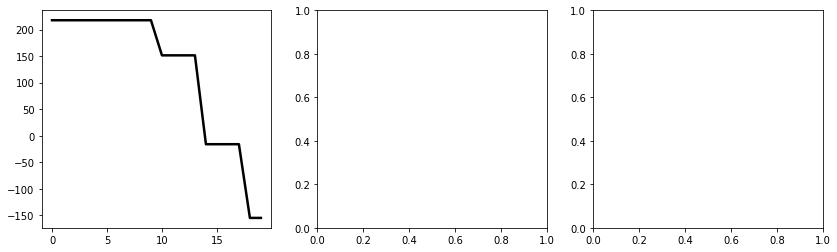

In [19]:
some_batch = next(iter(train_loader))[0][0][None, :]

fig, ax = plt.subplots(1, 3, figsize=(14,4))

joint_nb = np.random.randint(66)
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])[0, joint_nb].detach().numpy()
plot_features(out, ax[0])

joint_nb = np.random.randint(66)
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])[0, joint_nb].detach().numpy()
plot_features(out, ax[1])

joint_nb = np.random.randint(66)
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])[0, joint_nb].detach().numpy()
plot_features(out, ax[2])

plt.legend()
# plt.show()

plt.savefig('features.pdf')

In [22]:
class Conv1Channel(nn.Module):
    def __init__(self, nb_filters=1, filter_size=1, stride=1, dilation=1):
        super().__init__()
        self.conv = nn.Conv1d(1, nb_filters, filter_size, stride=stride, padding=0, dilation=dilation, groups=1,
                              bias=True, padding_mode='zeros')

    def forward(self, x):
        shape = x.shape
        x = x.reshape(-1, shape[-1])
        x = x[:, None, :]
        x = self.conv(x)
        x = x.reshape(shape[0], shape[1], -1)
        return x


class TimeInceptionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutions5 = nn.ModuleList([])
        self.convolutions10 = nn.ModuleList([])
        self.convolutions15 = nn.ModuleList([])
        self.convolutions20 = nn.ModuleList([])
        
        self.convolutions5.append(Conv1Channel(nb_filters=12, filter_size=2))
        self.convolutions5.append(Conv1Channel(nb_filters=12, filter_size=3))
        
        self.convolutions10.append(Conv1Channel(nb_filters=8, filter_size=5))
        self.convolutions10.append(Conv1Channel(nb_filters=8, filter_size=7))
        
        self.convolutions15.append(Conv1Channel(nb_filters=3, filter_size=9))
        self.convolutions15.append(Conv1Channel(nb_filters=3, filter_size=11))
        
        self.convolutions20.append(Conv1Channel(nb_filters=3, filter_size=7, dilation=2))
        self.convolutions20.append(Conv1Channel(nb_filters=3, filter_size=9, dilation=2))
        
#         self.output_size = self.forward(torch.ones(1, 1, 100)).shape[2]

    def forward(self, inpt):
        out = inpt[:, :, -10:]
        
        # 5 observed time indices
        x = inpt[:, :, -5:]
        for conv in self.convolutions5:
            y = conv(x)
            print(y.shape)
            out = torch.cat((out, y), 2)
        
        print(out.shape)
            
        # 10 observed time indices
        x = inpt[:, :, -10:]
        for conv in self.convolutions10:
            y = conv(x)
            print(y.shape)
            out = torch.cat((out, y), 2)
            
        # 15 observed time indices
        x = inpt[:, :, -15:]
        for conv in self.convolutions15:
            y = conv(x)
            print(y.shape)
            out = torch.cat((out, y), 2)
            
        # 20 observed time indices
        x = inpt[:, :, -20:]
        for conv in self.convolutions20:
            y = conv(x)
            print(y.shape)
            out = torch.cat((out, y), 2)
            
        return out

In [171]:
some_batch3, raw, all_seq = next(iter(train_loader))

In [172]:
observed = raw[:, :, :20]
model = TimeInceptionModule()
model(observed).shape

torch.Size([16, 66, 48])
torch.Size([16, 66, 36])
torch.Size([16, 66, 48])
torch.Size([16, 66, 32])
torch.Size([16, 66, 21])
torch.Size([16, 66, 15])
torch.Size([16, 66, 24])
torch.Size([16, 66, 12])


torch.Size([16, 66, 246])

In [29]:
joint_nb = np.random.randint(66)
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])
print(out.shape)
out = out[0, joint_nb].detach().numpy()
print(out.shape)
colors = {3:'red', 5:'blue', 7:'green'}

def plot_features(out, ax):
    plt.plot(np.arange(opt.input_n), out[:opt.input_n], label='joint trajectory', c='black', linewidth=2.5)
    out = out[opt.input_n:]
    for conv in model.time_inception_mod.convolutions5:
        for p in conv.parameters():
            if len(p.shape) == 3:
                for channel in range(p.shape[0]):
                    length = opt.input_n-p.shape[2]+1
                    seq = out[:length]
                    out = out[length:]
                    if p.shape[2] != 2:
                        print(p.shape)
                        print(length)
                        plt.plot(np.arange(length)+(p.shape[2]-1)//2, seq)

                        plt.xlabel('time index')
                        
# plt.legend()
# plt.show()

torch.Size([1, 66, 246])
(246,)


torch.Size([12, 1, 3])
18


ValueError: x and y must have same first dimension, but have shapes (18,) and (0,)

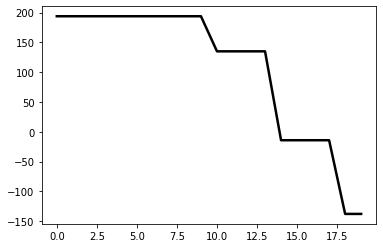

In [30]:
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])[0, joint_nb].detach().numpy()
plot_features(out, None)